# Sistem Rekomendasi Destinasi Wisata Kota Bandung Berbasis Collaborative Filtering
<hr>

#### Sumber data: https://www.kaggle.com/aprabowo/indonesia-tourism-destination
#### Oleh: [Rafka Imanda Putra](https://www.kaggle.com/rafkaip)

# Pendahuluan

<div>
<img src="https://static.limakaki.com/2017/07/slide_12.jpg" width="900";/>
</div>

Sebelum bepergian, biasanya seseorang akan membuat rencana terlebih dahulu tentang lokasi yang akan dikunjungi dan waktu keberangkatannya. Hal ini dilakukan untuk perencanaan sebelum berwisata ke suatu Kota. 

Kota Bandung memiliki daya tarik wisata yang cukup tinggi, namun dikutip dari humas.bandung.go.id/ jumlah wisatawan ke Kota Bandung turun 50% pada tahun 2021. Tentunya angka ini wajar karena penyebaran Covid-19 yang mengkhawatirkan di Indonesia. 

Untuk periode Oktober 2021, sejumlah wisata di Kota Bandung sudah mulai beroperasi, ini akan menjadi momentum yang tepat untuk menggerakkan pariwisata kembali.

Pada projek ini, saya akan membuat sebuah sistem rekomendasi berbasis collaborative filtering untuk menampilkan top-n recommendation destinasi wisata di Kota Bandung berdasarkan data user, rating, dan place

# Alur Proses

## 1. Mengimpor Library Python yang Dibutuhkan

In [1]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [2]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indonesia-tourism-destination/user.csv
/kaggle/input/indonesia-tourism-destination/tourism_rating.csv
/kaggle/input/indonesia-tourism-destination/package_tourism.csv
/kaggle/input/indonesia-tourism-destination/tourism_with_id.csv


##### Keterangan:
* tourism_with_id.csv - mengandung informasi tempak wisata di 5 kota besar di Indonesia (hanya kota Bandung yang dipakai)
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
* tourism_rating.csv - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating


## 3. Data Understanding

### 3.1 Menyiapkan Data

In [3]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('/kaggle/input/indonesia-tourism-destination/tourism_rating.csv')
place = pd.read_csv('/kaggle/input/indonesia-tourism-destination/tourism_with_id.csv')
user = pd.read_csv('/kaggle/input/indonesia-tourism-destination/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [4]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [5]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [6]:
# Merubah data agar hanya dari Kota Bandung

place = place[place['City']=='Bandung']
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
210,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,Cagar Alam,Bandung,30000,4.5,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-6.759638,107.609781
211,212,Jalan Braga,Jalan Braga adalah nama sebuah jalan utama di ...,Budaya,Bandung,0,4.7,NaN,"{'lat': -6.9150534, 'lng': 107.6089842}",-6.915053,107.608984


In [7]:
place.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 210 to 333
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      124 non-null    int64  
 1   Place_Name    124 non-null    object 
 2   Description   124 non-null    object 
 3   Category      124 non-null    object 
 4   City          124 non-null    object 
 5   Price         124 non-null    int64  
 6   Rating        124 non-null    float64
 7   Time_Minutes  50 non-null     float64
 8   Coordinate    124 non-null    object 
 9   Lat           124 non-null    float64
 10  Long          124 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 11.6+ KB


In [8]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [9]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [11]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Kota Bandung

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,9,211,3
1,26,211,2
2,40,211,3
3,40,211,2
4,70,211,5


In [12]:
# Melihat ukuran dataset rating untuk Kota Bandung

rating.shape

(2842, 3)

#### 3.2.3. Data user

In [13]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [14]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata di Kota Bandung

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
260,1,"Semarang, Jawa Tengah",20
1178,2,"Bekasi, Jawa Barat",21
279,3,"Cirebon, Jawa Barat",23
418,4,"Bekasi, Jawa Barat",21
1655,5,"Lampung, Sumatera Selatan",20


In [15]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

(300, 3)

## 4. Eksplorasi Data

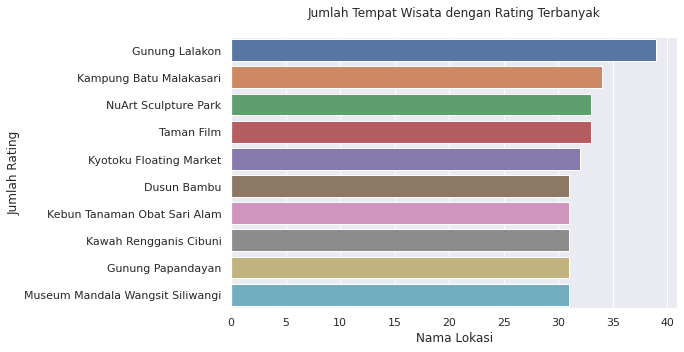

In [16]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', left_on='index', right_on='Place_Id')

# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8,5))
sns.barplot('Place_Id_x', 'Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Jumlah Rating')
plt.xlabel('Nama Lokasi')
plt.show()

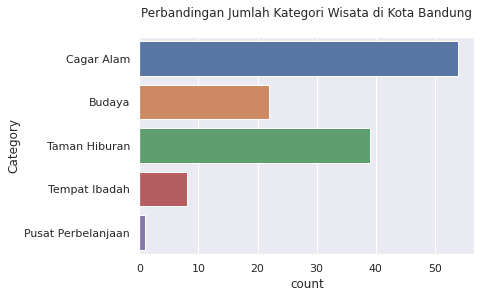

In [17]:
# Membuat visualisasi jumlah kategori wisata di Kota Bandung

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata di Kota Bandung', pad=20)
plt.show()

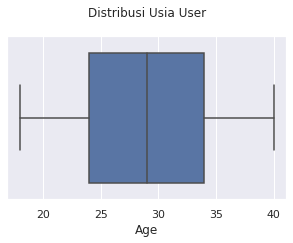

In [18]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

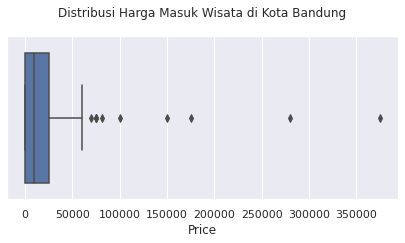

In [19]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata di Kota Bandung', pad=20)
plt.show()

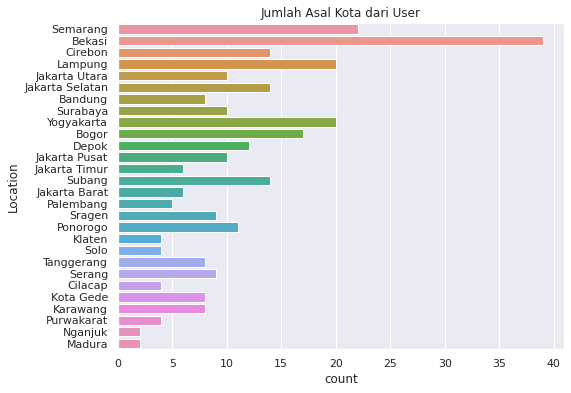

In [20]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [21]:
# Membaca dataset untuk dilakukan encoding
 
df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,9,211,3
1,26,211,2
2,40,211,3
3,40,211,2
4,70,211,5


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [22]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [23]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### 5.2.3. Encoding dan Mapping Kolom Place

In [24]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

### 5.3. Melihat Gambaran Data untuk Pemodelan

In [25]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
 
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 124, Min Rating: 1.0, Max Rating: 5.0


In [26]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
415,245,228,2.0,56,17
2233,44,309,3.0,45,98


## 6. Pemodelan Machine Learning dengan RecommenderNet

### 6.1. Membagi data train dan test

In [27]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### 6.2.1. Inisialisasi Fungsi

In [28]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_places = tf.tensordot(user_vector, places_vector, 2) 
 
    x = dot_user_places + user_bias + places_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

#### 6.2.2. Inisialisasi Model

In [29]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

#### 6.2.2. Inisialisasi Callbacks

In [30]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

#### 6.2.3. Proses Training

In [31]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

2021-10-27 02:47:59.542826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
72/72 [==============================] - 2s 6ms/step - loss: 0.7157 - root_mean_squared_error: 0.3564 - val_loss: 0.7249 - val_root_mean_squared_error: 0.3566
Epoch 2/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7145 - root_mean_squared_error: 0.3553 - val_loss: 0.7248 - val_root_mean_squared_error: 0.3565
Epoch 3/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7065 - root_mean_squared_error: 0.3501 - val_loss: 0.7236 - val_root_mean_squared_error: 0.3557
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7140 - root_mean_squared_error: 0.3550 - val_loss: 0.7227 - val_root_mean_squared_error: 0.3551
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7060 - root_mean_squared_error: 0.3498 - val_loss: 0.7222 - val_root_mean_squared_error: 0.3549
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7092 - root_mean_squared_error: 0.3520 - val_loss: 0.7214 - val_root_m

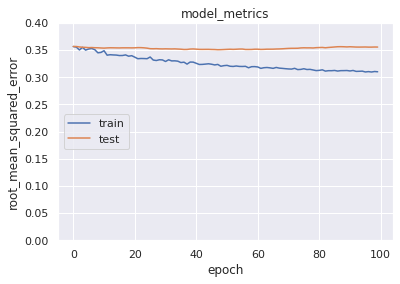

In [32]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

## 7. Memprediksi Top 7 Rekomendasi

#### 7.1 Menyiapkan DataFrame untuk Menampilkan Hasil Rekomendasi

In [33]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()

#### 7.2. Menyiapkan contoh User untuk Menampilkan Rekomendasi

#### 7.2.1 Mencari User

In [34]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

#### 7.2.2. Mencari Lokasi yang belum Dikunjungi User

In [35]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

### 7.3. Menampilkan Hasil Rekomendasi untuk User

In [36]:
# Mengambil top 7 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

Daftar rekomendasi untuk: User 192

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Museum Geologi Bandung : Budaya
Taman Lansia : Taman Hiburan
Curug Batu Templek : Cagar Alam
Situ Patenggang : Cagar Alam
Kota Mini : Taman Hiburan

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Dago Dreampark 
     Taman Hiburan , Harga Tiket Masuk  40000 , Rating Wisata  4.2 

2 . Stone Garden Citatah 
     Taman Hiburan , Harga Tiket Masuk  30000 , Rating Wisata  4.4 

3 . Museum Pos Indonesia 
     Budaya , Harga Tiket Masuk  0 , Rating Wisata  4.5 

4 . Masjid Agung Trans Studio Bandung 
     Tempat Ibadah , Harga Tiket Masuk  0 , Rating Wisata  4.8 

5 . Sanghyang Heuleut 
     Cagar Alam , Harga Tiket Masuk  10000 , Rating Wisata  4.4 

6 . Glamping Lakeside Rancabali

# Penutup

Model untuk menampilkan top 7 rekomendasi tempat wisata telah selesai dibuat dan model ini dapat digunakan untuk menampilkan rekomendasi kepada user yang harapannya dapat meningkatkan jumlah wisatawan di Kota Bandung. Namun demikian beberapa pengembangan lain masih dapat dilakukan agar dapat membuat model yang menampilkan rekomendasi yang lebih sesuai dengan kebiasaan pengguna, dll.

## *Referensi*

* Seaborn : https://seaborn.pydata.org/tutorial.html
* Callback : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
* Lainnya:
  * https://github.com/AgungP88/getloc-apps/tree/machine-learning
  * https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
  * https://www.kaggle.com/aprabowo/indonesia-tourism-destination
  * https://www.dicoding.com/academies/319